I should write stuff here

## Notes to self
- I removed clm, numclaims. Only focusing on claimcst0. Is there a way to train the model on clm, numclaims such that it somehow improves the accuracy???
- Alot of the claimcst0 have no values and only a few have non-zero value, is there something we can do here???

### Imports & Global Variables

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# place imports back here
import warnings
warnings.filterwarnings("ignore", "is_sparse")

In [281]:
import os, sys
PATH = %pwd
PATH = PATH.split(os.path.sep)
PATH = os.path.sep.join(PATH[:-2]) #removes last 2 directories, gets path to repository

### Preprocessing
- Imbalanced Data
    - Training dataset's target values (**y_test**) is 94% zero, when 6% non-zero values
    - Sol: Data augmentation
- 



In [282]:
# (1) Read both train/test + validation & preform equal preprocessing on it
df_t = pd.read_csv(os.path.join(PATH, 'dataset', 'InsNova_data_2023_train.csv'))
df_v = pd.read_csv(os.path.join(PATH, 'dataset', 'InsNova_data_2023_vh.csv'))

In [283]:
col_categorical = ['veh_body', 'gender', 'area', 'engine_type', 'veh_color', 
                'marital_status', 'time_of_week_driven', 'time_driven']
col_continuous = ['veh_value', 'exposure', 'credit_score']
col_discrete = ['veh_age', 'agecat', 'max_power', 'driving_history_score',
                'e_bill', 'trm_len', 'high_education_ind']
col_target = ['claimcst0']

In [284]:
claimcst0_percentage = (len(df_t[(df_t['claimcst0'] > 0)])/len(df_t['claimcst0']))*100
print(f"df_t claimcst0 percentage: {claimcst0_percentage}%")

df_t claimcst0 percentage: 6.817277510057916%


In [285]:
col_categorical = ['veh_body', 'gender', 'area', 'engine_type', 'veh_color', 
                'marital_status', 'time_of_week_driven', 'time_driven']
col_continuous = ['veh_value', 'exposure', 'credit_score']
col_discrete = ['veh_age', 'agecat', 'max_power', 'driving_history_score',
                'e_bill', 'trm_len', 'high_education_ind']

# (2) Feature Manipulation
# (2.1) Continuous/Discrete scaling
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df_t[col_continuous] = rs.fit_transform(df_t[col_continuous])
df_t[col_discrete] = rs.fit_transform(df_t[col_discrete])

df_v[col_continuous] = rs.fit_transform(df_v[col_continuous])
df_v[col_discrete] = rs.fit_transform(df_v[col_discrete])

# (2.2) Categorical processing
df_t = pd.get_dummies(data=df_t,columns=col_categorical, dtype=float)
df_v = pd.get_dummies(data=df_v,columns=col_categorical, dtype=float)


# Replace whitespace with underscore ' ' -> '_'
df_t.columns = df_t.columns.str.replace(' ', '_')
df_v.columns = df_v.columns.str.replace(' ', '_')


df_t = df_t.drop(columns=['clm','numclaims'])
df_t = df_t.reset_index(drop=True)

df_v = df_v.reset_index(drop=True)

In [286]:
'''
df_t_zero = df_t[df_t['claimcst0'] == 0]
df_t_non_0 = df_t[df_t['claimcst0'] > 0]

factor = len(df_t_zero)//len(df_t_non_0)
df_t_non_0 = factor * df_t_non_0
train_df = pd.concat([df_t_zero,df_t_non_0], axis=0)
train_df = pd.concat([df_t_zero[:df_t_non_0.shape[0]],df_t_non_0], axis=0)
'''

"\ndf_t_zero = df_t[df_t['claimcst0'] == 0]\ndf_t_non_0 = df_t[df_t['claimcst0'] > 0]\n\nfactor = len(df_t_zero)//len(df_t_non_0)\ndf_t_non_0 = factor * df_t_non_0\ntrain_df = pd.concat([df_t_zero,df_t_non_0], axis=0)\ntrain_df = pd.concat([df_t_zero[:df_t_non_0.shape[0]],df_t_non_0], axis=0)\n"

In [319]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
X = df_t.drop(['id'], axis=1)
y = df_t['claimcst0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


params = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'metric':'mape',
        'learning_rate': 0.01,
        'scale_pos_weight': 16,  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': 31,  # -1 means no limit
        'min_child_samples': 10,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.8,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'nthread': 4,
        'verbose': 0,
        'lambda_l2': 0.1,
    }
lgtrain = lgb.Dataset(X_train, label=y_train)
lgval = lgb.Dataset(X_test, label=y_test)

evals_result = {}
model = lgb.train(params, lgtrain, 5000, 
                    valid_sets=[lgtrain, lgval], 
                    early_stopping_rounds=100, 
                    verbose_eval=150, 
                    evals_result=evals_result)

pred_test_y = model.predict(X_test, num_iteration=model.best_iteration)

/Users/jb/anaconda3/envs/Kaggle-Travelers/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/jb/anaconda3/envs/Kaggle-Travelers/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/jb/anaconda3/envs/Kaggle-Travelers/lib/python3.11/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callba

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[150]	training's mape: 52.6109	valid_1's mape: 52.8241
[300]	training's mape: 18.0623	valid_1's mape: 18.2619
[450]	training's mape: 5.56645	valid_1's mape: 5.66791
[600]	training's mape: 1.89212	valid_1's mape: 1.94126
[750]	training's mape: 0.716897	valid_1's mape: 0.74896
[900]	training's mape: 0.320763	valid_1's mape: 0.348268
[1050]	training's mape: 0.13832	valid_1's mape: 0.163977
[1200]	training's mape: 0.0498079	valid_1's mape: 0.0751087
[1350]	training's mape: 0.0219515	valid_1's mape: 0.0479733
[1500]	training's mape: 0.0107524	valid_1's mape: 0.037376
[1650]	training's mape: 0.00631801	valid_1's mape: 0.0335639
[1800]	training's mape: 0.00419251	valid_1's mape: 0.0319446
[1950]	training's 

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='mape'>

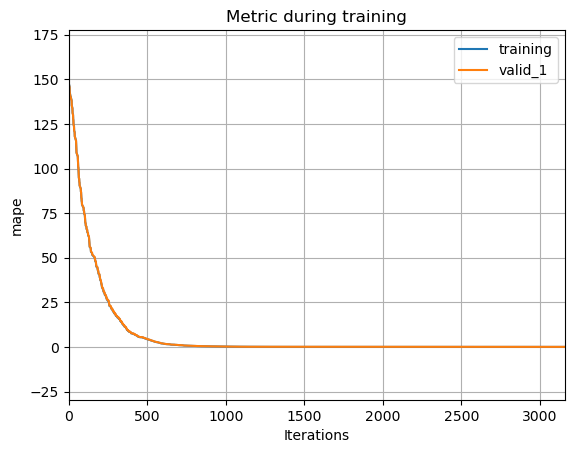

In [320]:
lgb.plot_metric(booster=evals_result)

In [321]:
val_outputs = model.predict(df_v)
#val_outputs = np.sort(val_outputs)
val_outputs[val_outputs < 1] = 0

val_outputs = pd.DataFrame(val_outputs, columns=['Predict'])
val_outputs.rename_axis('id', inplace=True)
val_outputs.index += 1
val_outputs.to_csv('Tree_Submission.csv', index=True)